# Table of Contents 
* Import Libraries
* About Data
    * EV DC Fast Chargers
    * EV Vehicles
    * 2022 Estimated Demographics data
    * California Zip Codes
* Data Loading
* Data Exploration
    * EV DC Fast Chargers Analysis
    * EV Vehicles Analysis
    * 2022 Estimated Demographics data Analysis
    * California Zip Codes Analysis
* Data Processing
    * Duplicate datesets
    * Rename columns
    * Merge all datasets by zipcode
* Modeling
    * K-Means Algorithm
        * Chargers dataset
            * Optimal clusters using Elbow method
            * Optimal clusters using Silhouette method
            * Model with optimal clusters
            * Visualizations
        * Unified dataset
            * Optimal clusters using Elbow method
            * Optimal clusters using Silhouette method
            * Model with optimal clusters
            * Visualizations
    * DBSCAN Clustering Algorithm
        * Chargers dataset
            * Optimium epsilon and cluster
            * Model with optimal clusters
            * Visualizations
        * Unified dataset
            * Optimium epsilon and cluster
            * Model with optimal clusters
            * Visualizations
    * Hierarchical Clustering Algorithm
        * Single Linkage
        * Complete Linkage       
* t-SNE Visualization
    * Chargers dataset
    * Unified dataset

## Import Libraries <a id="import"></a>

In [3]:
#New packages installed
#pip install folium geopandas fiona yellowbrick kneed

In [4]:
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import json
import geopandas as gdp
import plotly.express as px

#Modeling
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator


import warnings 
warnings.filterwarnings('ignore')

## About Data <a id="about"></a>

The data is only for California state in USA. Also, has only partial data for the year 2024.

### EV DC Fast Chargers <a id="evchargers"></a>

This dataset comprises of California's EV DC Fast Chargering Stations. This data was taken from [here](https://www.energy.gov/). Below are its features listed.

* station name - Name of EV Charging Station
* open year - Charging Station opening year
* Facility Type - categorical, type of facility
* Address Fields
    * city - Name of the city
    * zip - postal zipcode
    * latitude - Latitude of station
    * longtitude - Longitude of station
* Chargers count - Number of EV DC Fast Charger available in that station
* EV Network Name - Name of EV Charging OCPI Network
* workplace charging - yes/no, is this located in work place




### EV Vehicles <a id="evvehicles"></a>

This data has number of EV Vehicle added each year per zipcode. This dataset contains year, zip, number of EV vehicles. This data was taken from [here](https://www.energy.ca.gov/).

* year - calendar year
* zip - california zipcode
* vehicles - Number of EV vehicles

### 2022 Estimated Demographics data <a id="demographics"></a>

This data comprises of 2022 Estimated Califronia Demographics information for each california zipcode. This dataset can be found [here](https://data.census.gov/).

1. zip - California postal zipcode
2. total households - total number of households 
3. family households - number of family households 
4. non-family households - number of non-family households 
5. family household median income - 
6. non-family household median income -
7. total population -
8. All male - number of male population 
9. All female - number of female population
10. Male_18+ - number of male population who are 18 years or older
11. Female_18+ - number of female population who are 18 years or older
12. White_population - white population count
13. Black_population - black population count
14. Asian - asian population count
15. Asian Indian - Indian population count
16. Asian Chinese -  chinese population count

### California Zip Codes <a id="zipcodes"></a>

This is geojson file containing all California zip codes. This data is needed for better visualation and was taken from [here](https://gis.data.ca.gov/).

## Data Loading <a id="dataloading"></a>

In [16]:
#DC Fast Chargers across California state
chargers = pd.read_excel("data/ev_chargers.xlsx")

In [17]:
# EV Vehicles sold per zipcode in California each year
vehicles = pd.read_excel("data/ev_vehicles.xlsx")

In [18]:
# California demographics, houshold, sex, median income information for the year 2022
demographics = pd.read_excel("data/2022_demographics.xlsx")

In [19]:
# Caifornia zipcodes
zips = gdp.read_file("data/zipcodes.geojson")

## Data Exploration <a id="dataanalysis"></a>

### EV DC Fast Chargers Analysis <a id="evchargersanalysis"></a>

In [22]:
chargers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Station Name        2331 non-null   object 
 1   City                2331 non-null   object 
 2   Zip                 2331 non-null   int64  
 3   Chargers Count      2331 non-null   int64  
 4   Open Year           2331 non-null   int64  
 5   Facility Type       891 non-null    object 
 6   Latitude            2331 non-null   float64
 7   Longitude           2331 non-null   float64
 8   EV Network          2331 non-null   object 
 9   Workplace Charging  2331 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(4)
memory usage: 166.3+ KB


In [23]:
chargers.head(5)

,Station Name,City,Zip,Chargers Count,Open Year,Facility Type,Latitude,Longitude,EV Network,Workplace Charging
0,Jordan Downs,Los Angeles,90002,2,2022,NaN,33.946716,-118.229940,EVCS,False
1,Solair Wilshire,Los Angeles,90010,4,2023,PARKING_LOT,34.062770,-118.308710,EVGATEWAY,False
2,LA County ISD Walt Disney Parking Garage P3,Los Angeles,90012,3,2014,PAY_GARAGE,34.055505,-118.248852,POWERFLEX,False
3,LA County DHS 313 Fig,Los Angeles,90012,6,2014,PAY_GARAGE,34.060148,-118.250747,POWERFLEX,False
4,LADWP - Crenshaw,Los Angeles,90012,4,1999,UTILITY,34.012230,-118.334323,Non-Networked,True


In [24]:
#Map visualization using Folium
#using california latitude, longitude as map center
charging_map = folium.Map(location=(36.778259, -119.417931), zoom_start=6)

marker_cluster = MarkerCluster(name="Charging Stations").add_to(charging_map)

#adding all the EV charging station to map
for index, row in chargers.iterrows():
    popup_text = f"<b>{row['Station Name']}</b>"
    folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text, line_opacity=10).add_to(marker_cluster)

#Display map visualization
print("\n Map visualization of EV DC Fast Charging Stations across California \n")

#charging_map
# saving it locally and embedding IFrame since 
charging_map.save("map.html")

#embedding IFrame for github visualization
from IPython.display import IFrame
IFrame(src="map.html", width=1000, height=600)


 Map visualization of EV DC Fast Charging Stations across California 



**Unfortunately Folium map isn't visible in github, its visible when we run this on jupyter notebook. So I have attached a snapshot for reference**

![MAP](map.png) 

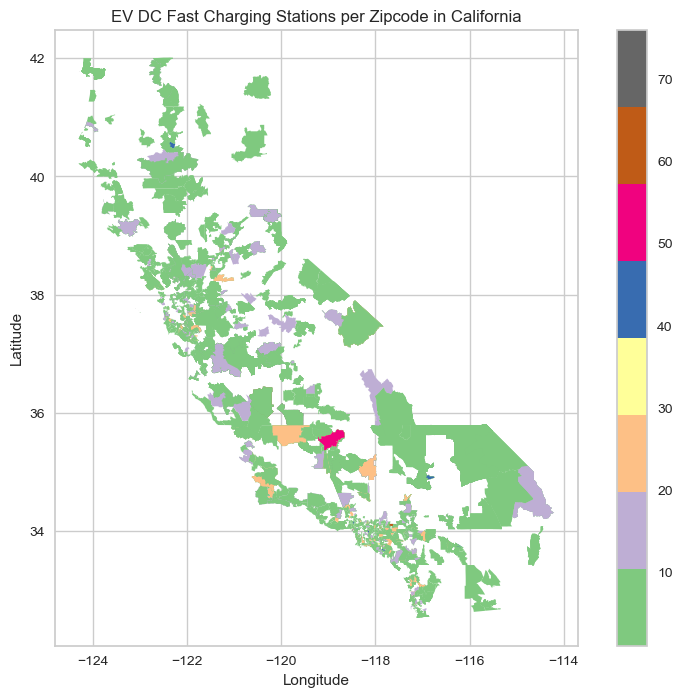

In [27]:
#converting string zip_code column to int for merging
zips["ZIP_CODE"]=zips["ZIP_CODE"].astype("int")

#mergers chargers and califronia zip dataframe by zip code for visualization
zip_chargers_df = zips.merge(chargers, left_on="ZIP_CODE" , right_on="Zip")
zip_chargers_df.plot(column="Chargers Count", legend=True, figsize=(10, 8), cmap="Accent")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("EV DC Fast Charging Stations per Zipcode in California")
plt.show()

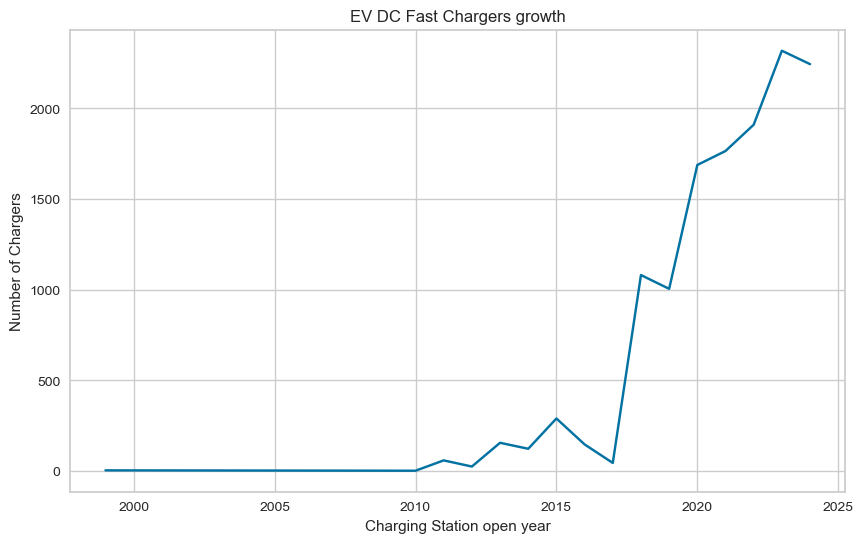

In [28]:
#Chargers growth visualization
plt.figure(figsize=(10,6))
sns.lineplot(chargers[["Open Year","Chargers Count"]].groupby("Open Year").sum()["Chargers Count"])
plt.title("EV DC Fast Chargers growth")
plt.xlabel("Charging Station open year")
plt.ylabel("Number of Chargers")
plt.show()

### EV Vechicles Analysis <a id="evvehicleanalysis"></a>

In [30]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32341 entries, 0 to 32340
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   year      32341 non-null  int64
 1   zip       32341 non-null  int64
 2   vehicles  32341 non-null  int64
dtypes: int64(3)
memory usage: 758.1 KB


In [31]:
vehicles.head(5)

,year,zip,vehicles
0,1998,90404,1
1,1998,91709,2
2,1998,94063,1
3,1999,93102,1
4,2001,90731,1


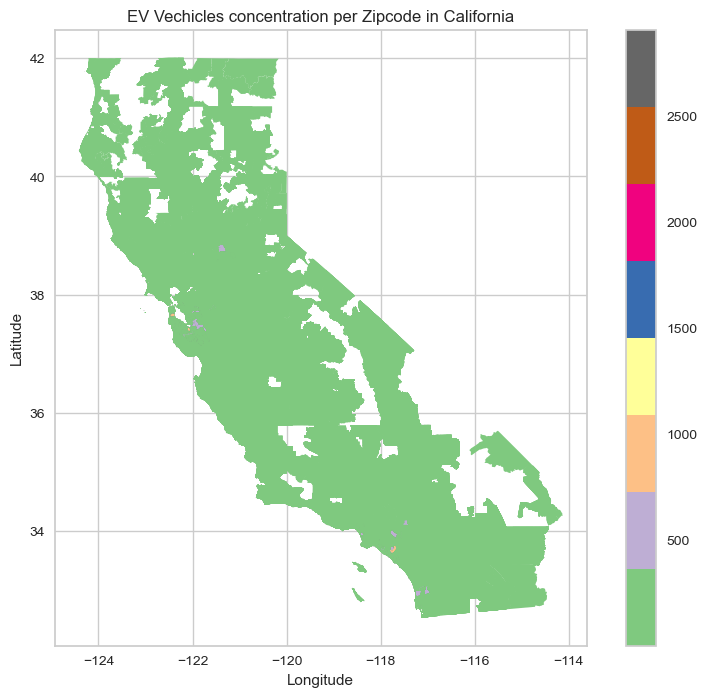

In [32]:
#creating string type of zipcode 
#vehicles["zip_str"] = vehicles["zip"].astype("str")
#zips["zip"]=zips["ZIP_CODE"].astype("int")

zip_vehicles = zips.merge(vehicles, left_on="ZIP_CODE" , right_on="zip")
zip_vehicles.plot(column="vehicles", legend=True, figsize=(10, 8), cmap="Accent")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("EV Vechicles concentration per Zipcode in California")
plt.show()

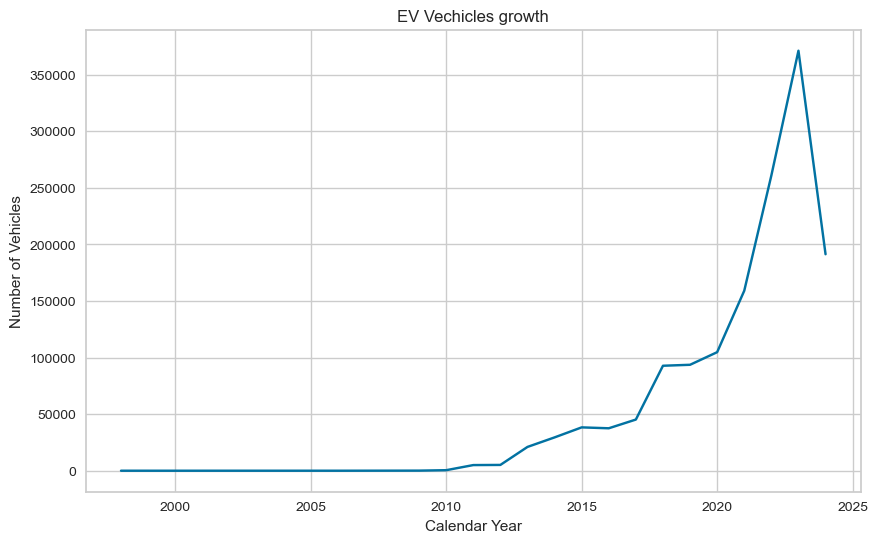

In [33]:
#Vehicles growth visualization
plt.figure(figsize=(10,6))
sns.lineplot(vehicles.groupby("year").sum()["vehicles"])
plt.title("EV Vechicles growth")
plt.xlabel("Calendar Year")
plt.ylabel("Number of Vehicles")
plt.show()

### 2022 Estimated Demographics data Analysis<a id="demographicsanalysis"></a>

In [35]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   zip                                 1808 non-null   int64
 1   Total households                    1808 non-null   int64
 2   Family Households                   1808 non-null   int64
 3   Nonfamily households                1808 non-null   int64
 4   Family Household median income      1808 non-null   int64
 5   Non Family Household median income  1808 non-null   int64
 6   Total population                    1808 non-null   int64
 7   All Male                            1808 non-null   int64
 8   All Female                          1808 non-null   int64
 9   Male_18+                            1808 non-null   int64
 10  Female_18+                          1808 non-null   int64
 11  White_population                    1808 non-null   int64
 12  Black_

In [36]:
demographics.head(5)

,zip,Total households,Family Households,Nonfamily households,Family Household median income,Non Family Household median income,Total population,All Male,All Female,Male_18+,Female_18+,White_population,Black_population,Asian,Asian Indian,Asian Chinese
0,89010,188,127,61,71307,25250,461,258,203,223,168,406,0,0,0,0
1,89019,1150,586,564,97917,24701,2312,1331,981,1294,873,1874,79,197,0,0
2,89060,5129,2908,2221,56992,40006,12198,6041,6157,5468,4815,9041,202,126,4,63
3,89061,3326,2432,894,68606,38766,7529,4024,3505,3361,3197,6248,111,102,0,0
4,89439,834,525,309,122868,0,1639,932,707,809,638,1475,0,32,0,0


### California Zip Codes Analysis<a id="zipcodesanalysis"></a>

In [38]:
zips.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1721 entries, 0 to 1720
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    1721 non-null   int64   
 1   ZIP_CODE    1721 non-null   int64   
 2   PO_NAME     1721 non-null   object  
 3   STATE       1721 non-null   object  
 4   POPULATION  1721 non-null   int64   
 5   POP_SQMI    1721 non-null   float64 
 6   SQMI        1721 non-null   float64 
 7   geometry    1721 non-null   geometry
dtypes: float64(2), geometry(1), int64(3), object(2)
memory usage: 107.7+ KB


In [39]:
zips.head(5)

,OBJECTID,ZIP_CODE,PO_NAME,STATE,POPULATION,POP_SQMI,SQMI,geometry
0,1,12,Mt Meadows Area,CA,-99,-99.0,30.92,"POLYGON ((-120.84352 40.24962, -120.8436 40.24..."
1,2,16,Sequoia National Forest,CA,-99,-99.0,39.33,"POLYGON ((-118.44021 35.55794, -118.38035 35.5..."
2,3,17,Northeast Fresno County,CA,-99,-99.0,564.38,"POLYGON ((-118.77501 37.46305, -118.77447 37.4..."
3,4,18,Los Padres Ntl Forest,CA,-99,-99.0,90.83,"POLYGON ((-118.81778 34.56244, -118.81779 34.5..."
4,5,19,Lassen Ntl Forest,CA,-99,-99.0,412.59,"POLYGON ((-119.99861 40.77159, -119.99848 40.7..."


## Data Processing <a id="dataprocessing"></a>

### Duplicate datasets  <a id="duplicatedatasets"></a>

In [42]:
#duplicating df for processing
chargers_df = chargers.copy()
vehicles_df= vehicles.copy()
demographics_df = demographics.copy()
zip_df = zips[["ZIP_CODE"]]


### Rename columns  <a id="renamecolumns"></a>

In [44]:
#changing column names to lower case and replacing space with underscore
chargers_df.columns = [c.lower() for c in chargers_df.columns]
chargers_df.columns = chargers_df.columns.str.replace(' ', '_')

vehicles_df.columns = [c.lower() for c in vehicles_df.columns]
vehicles_df.columns = vehicles_df.columns.str.replace(' ', '_')

demographics_df.columns = [c.lower() for c in demographics_df.columns]
demographics_df.columns = demographics_df.columns.str.replace(' ', '_')



In [45]:
#renaming column to be consistent with other dataset and consider only 5 digit zipcode
zip_df.columns=["zip"]
zip_df = zip_df.query("zip > 1000")

### Merge all datasets by zipcode [Unified Dataset]  <a id="allinclusive"></a>

In [47]:
#Group Vehicles by zip
vehicles_df=vehicles_df.groupby("zip").sum()[["vehicles"]]
vehicles_df = vehicles_df.reset_index()

In [48]:
#Group chargers by zip
zip_chargers_df = chargers_df[["zip","chargers_count"]].groupby("zip").sum()
zip_chargers_df =zip_chargers_df.reset_index()

In [49]:
#merge all dataset into single df based on zipcode

#step 1
#merge zip, chagers df
temp_zip_charger_df = pd.merge(zip_df , zip_chargers_df,how="left", on="zip")
#for zip which doesnt have chargers, add 0
temp_zip_charger_df = temp_zip_charger_df.fillna(0)

#step 2
#merge step 1 results with vehicles df
temp_zip_charger_vehicles_df = pd.merge(temp_zip_charger_df , vehicles_df , how="left", on="zip")
#for zip which doesnt have chargers, add 0
temp_zip_charger_vehicles_df = temp_zip_charger_vehicles_df.fillna(0)

#merge step 2 results with demographics df
all_inclusive_df = pd.merge(temp_zip_charger_vehicles_df , demographics_df , how="left", on="zip")
all_inclusive_df=all_inclusive_df.dropna()

#consider zipcode which some population i.e. ignoring national/reserved forest zipcodes
all_inclusive_df=all_inclusive_df.query("total_population > 0 ")

#During merge int columns get converted to float, so changing columns back to int type
all_inclusive_df = all_inclusive_df.astype(int)


all_inclusive_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1656 entries, 0 to 1687
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   zip                                 1656 non-null   int64
 1   chargers_count                      1656 non-null   int64
 2   vehicles                            1656 non-null   int64
 3   total_households                    1656 non-null   int64
 4   family_households                   1656 non-null   int64
 5   nonfamily_households                1656 non-null   int64
 6   family_household_median_income      1656 non-null   int64
 7   non_family_household_median_income  1656 non-null   int64
 8   total_population                    1656 non-null   int64
 9   all_male                            1656 non-null   int64
 10  all_female                          1656 non-null   int64
 11  male_18+                            1656 non-null   int64
 12  female_18+ 

In [50]:
all_inclusive_df.head(5)

,zip,chargers_count,vehicles,total_households,family_households,nonfamily_households,family_household_median_income,non_family_household_median_income,total_population,all_male,all_female,male_18+,female_18+,white_population,black_population,asian,asian_indian,asian_chinese
0,90001,0,226,13597,11376,2221,59176,26696,57652,29102,28550,20808,19843,16284,4295,348,64,24
1,90002,2,201,13013,10575,2438,57212,21281,53108,26040,27068,18150,19679,12306,8355,611,104,250
2,90003,0,230,17936,14545,3391,53272,23082,75024,37793,37231,24755,26658,12889,12352,350,77,93
3,90004,0,1907,23047,12161,10886,63444,52430,58833,29865,28968,23952,24044,17019,2619,14584,485,789
4,90005,0,1067,16607,7790,8817,58545,38586,37754,19019,18735,15520,15663,7371,2006,12305,103,1084


## Modeling <a id="modelling"></a>

### K-Mean Clustering Alogrithm <a id="kmeans"></a>

#### Chargers dataset <a id="chargersonly"></a>

In [61]:
#Drop not so significant columns and null entries
chargers_df = chargers_df.drop(columns=["station_name", "open_year","workplace_charging"])
chargers_df.dropna(inplace=True)

In [62]:
#Encoding categorical columns
categorical_columns = ["city","facility_type","ev_network"]
encoder = LabelEncoder()
for col in categorical_columns:
    encoder.fit(chargers_df[col])
    chargers_df[col] = encoder.transform(chargers_df[col])


In [63]:
#Scale data
chargers_scaled_df = StandardScaler().fit_transform(chargers_df)

#### Optimal clusters using Elbow method <a id="elbow1"></a>

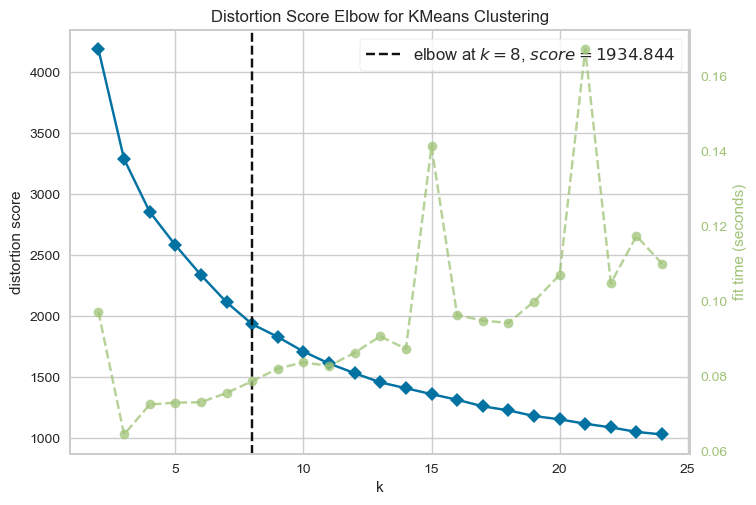

In [65]:
#Kmeans Clustering using elbow method
visualizer= KElbowVisualizer(KMeans(random_state=21), k=(2,25), timings= True)
#Fitting the data to the visualizer
visualizer.fit(chargers_scaled_df)  
#Render the figure
visualizer.show()  
plt.show()

**From the above elbow method, optimal K is identified as 8**

#### Optimal clusters using Silhouette method <a id="silhouette1"></a>

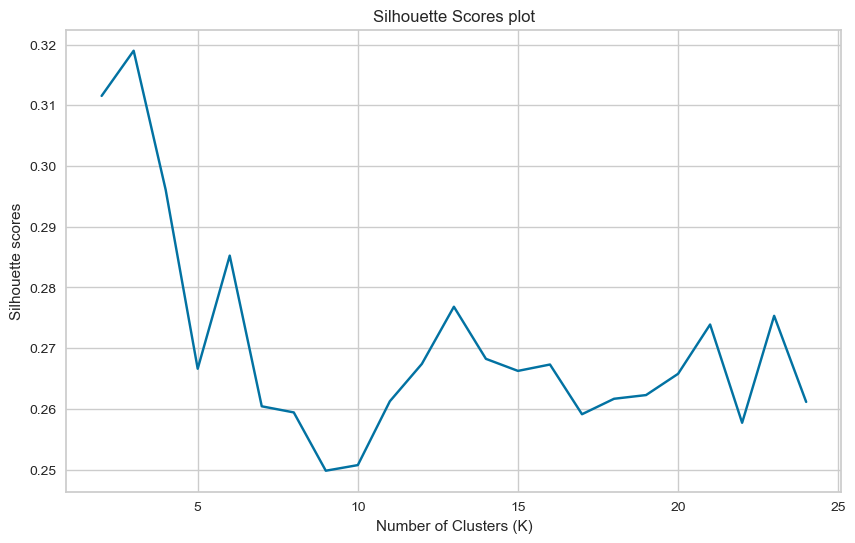

In [68]:
K = range(2, 25)
scores = []

for k in K:
    # train the model for current value of k 
    model = KMeans(n_clusters = k, random_state = 21).fit(chargers_scaled_df)
        
    # Append the silhouette score to scores
    scores.append(silhouette_score(chargers_scaled_df, model.labels_, metric='euclidean'))

#Visualization of scores to identify optimal number of clusters
plt.figure(figsize=(10,6))
sns.lineplot(x = K, y = scores)

plt.title("Silhouette Scores plot")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette scores")

plt.show()

**From the above silhouette score plot, optimal K value happens to be 7.** We will use 7 as K value for analysis.


#### Model with optimal clusters <a id="model1"></a>

In [71]:
#Kmeans model with 9 clusters
kmeans_chargers = KMeans(n_clusters=7, max_iter=1000, n_init="auto", random_state=0).fit(chargers_scaled_df)

#### Visualizations <a id="visualization1"></a>

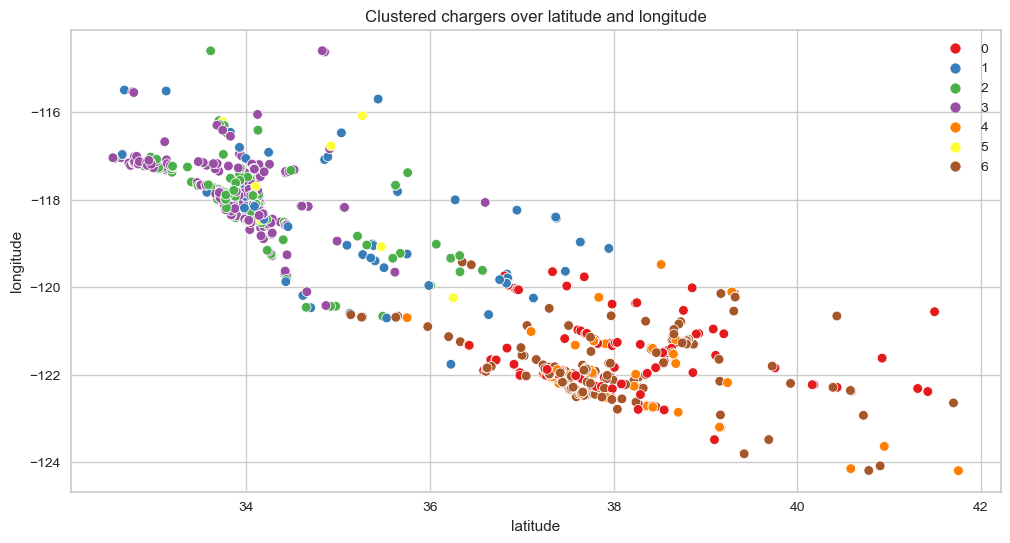

In [73]:
#Scatter plot of Lat, Log clustering
plt.figure(figsize=(12,6))
sns.scatterplot(data=chargers_df, x ="latitude", y="longitude", 
                hue = kmeans_chargers.labels_, 
                palette="Set1")
plt.title("Clustered chargers over latitude and longitude")
plt.show()

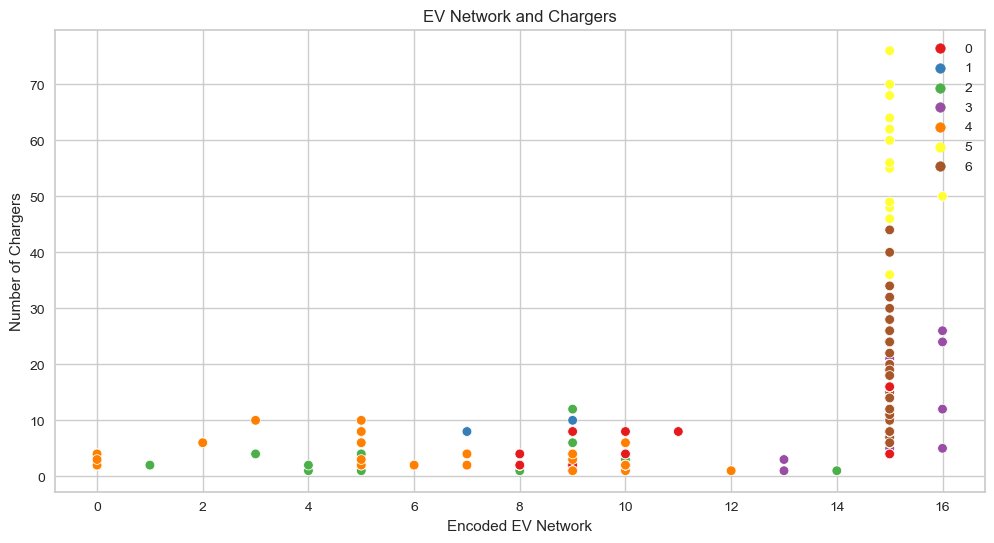

In [74]:
#Scatter plot of Ev Network and chargers
plt.figure(figsize=(12,6))

sns.scatterplot(data=chargers_df, y ="chargers_count", x="ev_network", 
                hue = kmeans_chargers.labels_, 
                palette="Set1")
plt.title("EV Network and Chargers")
plt.xlabel("Encoded EV Network")
plt.ylabel("Number of Chargers")
plt.show()

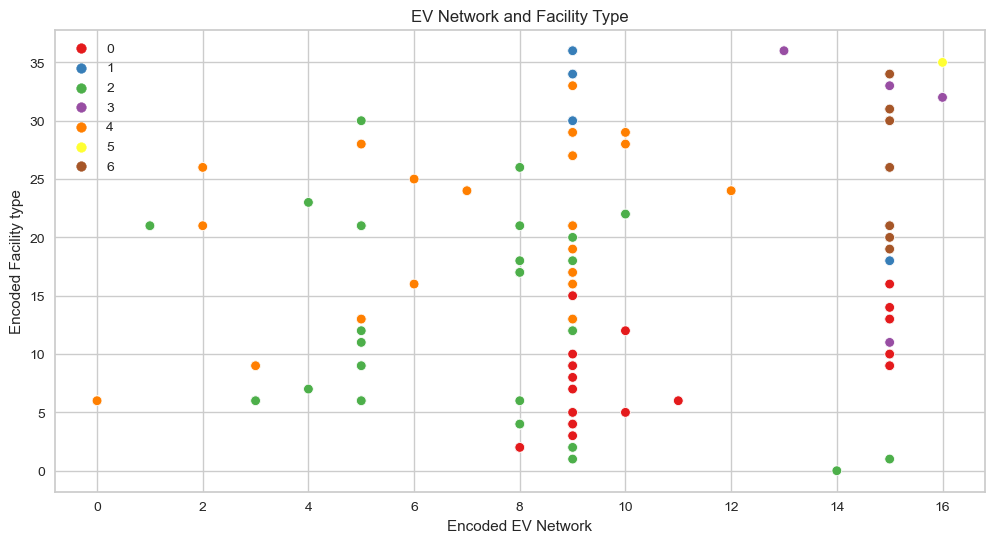

In [75]:
#Scatter plot of Ev Network and Facility Type
plt.figure(figsize=(12,6))

sns.scatterplot(data=chargers_df, y ="facility_type", x="ev_network", 
                hue = kmeans_chargers.labels_, 
                palette="Set1")
plt.title("EV Network and Facility Type")
plt.xlabel("Encoded EV Network")
plt.ylabel("Encoded Facility type")
plt.show()

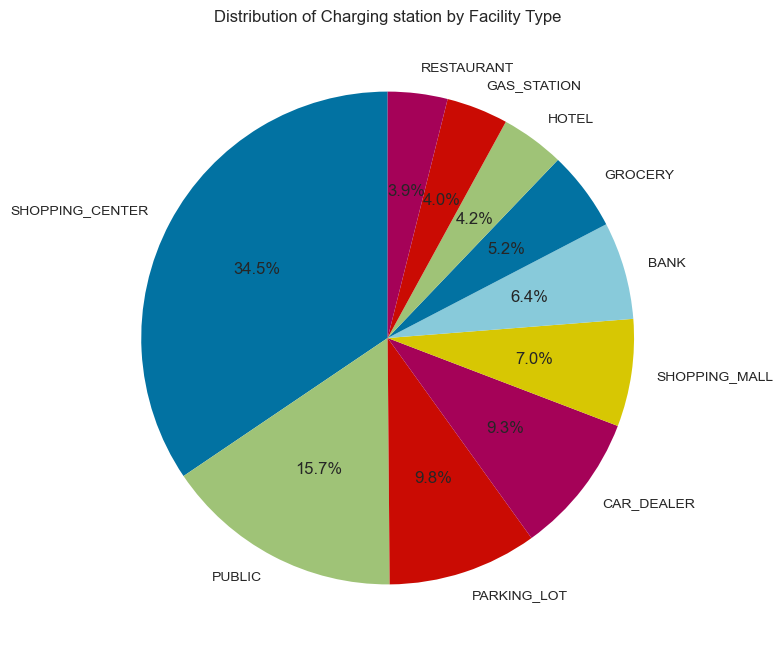

In [76]:
#Pie Chart showing top 10 facility types
plt.figure(figsize=(10, 8))
plt.pie(chargers["Facility Type"].value_counts()[:10], labels=chargers["Facility Type"].value_counts()[:10].index, 
        autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Charging station by Facility Type')

# Show the plot
plt.show()

### Unified dataset <a id="unifieddata"></a>

In [78]:
#Scale data
scaled_df = StandardScaler().fit_transform(all_inclusive_df)

#### Optimal clusters using Elbow method <a id="elbow2"></a>

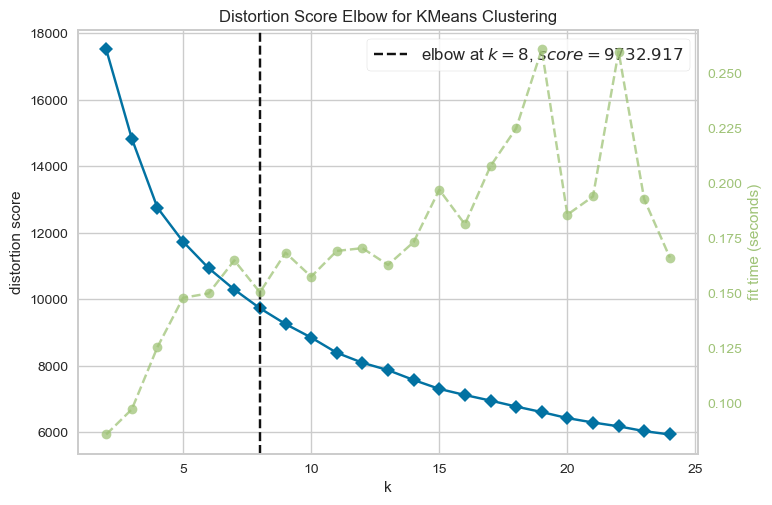

In [80]:
#Kmeans Clustering using Elbow Plot
visualizer= KElbowVisualizer(KMeans(random_state=21),k=(2,25),  timings= True)
#Fit the data
visualizer.fit(scaled_df)  

#visualize data
visualizer.show() 
plt.show()

**From the above elbow method, optimal K is identified as 8**

#### Optimal clusters using Silhouette method <a id="silhouette2"></a>

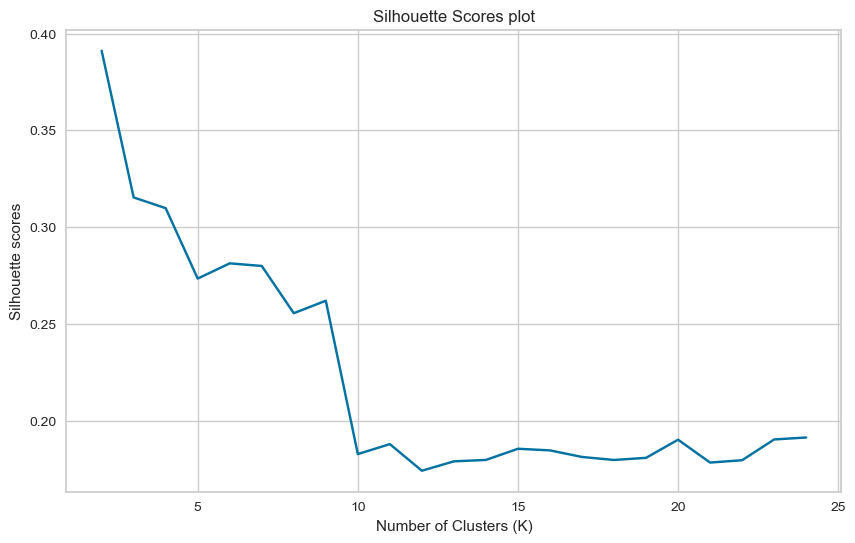

In [83]:
K = range(2, 25)
scores = []

for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 21, n_init='auto').fit(scaled_df)
        
    # Append the silhouette score to scores
    scores.append(silhouette_score(scaled_df, model.labels_, metric='euclidean'))

#Visualization of scores to identify optimal number of clusters
plt.figure(figsize=(10,6))
sns.lineplot(x = K, y = scores)

plt.title("Silhouette Scores plot")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette scores")

plt.show()

**From the above silhouette score plot, optimal K value happens to be 9.** We will use 9 as K value for analysis.

#### Model with optimal clusters <a id="model2"></a>

In [86]:
#Kmeans model with 9 clusters
kmeans_all = KMeans(n_clusters=9, max_iter=1000, n_init="auto", random_state=0).fit(scaled_df)

#### Visualizations <a id="visualization2"></a>

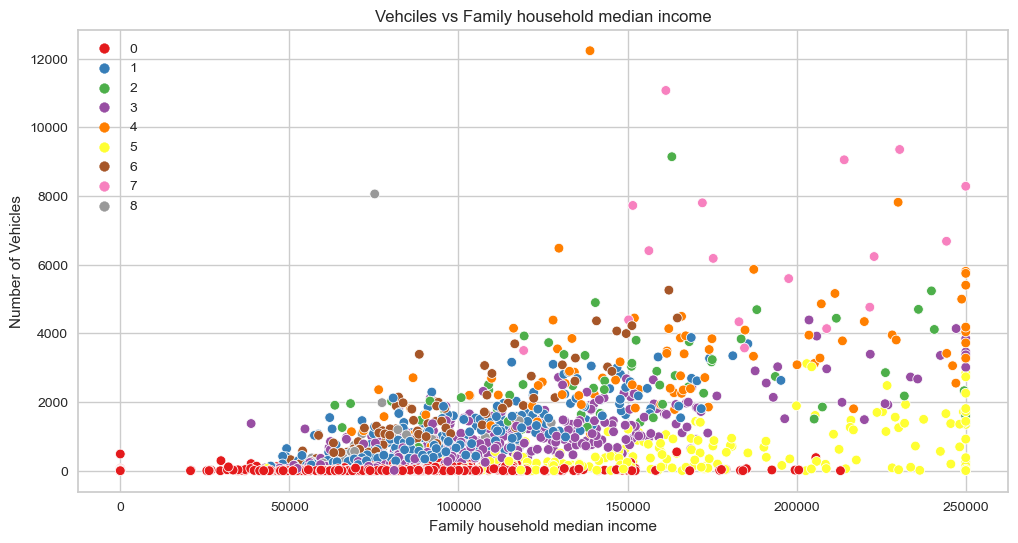

In [88]:
#Scatter plot of vehicles and family household median income
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="vehicles", x ="family_household_median_income", 
                hue = kmeans_all.labels_, palette="Set1")
plt.title("Vehciles vs Family household median income")
plt.xlabel("Family household median income")
plt.ylabel("Number of Vehicles")
plt.show()

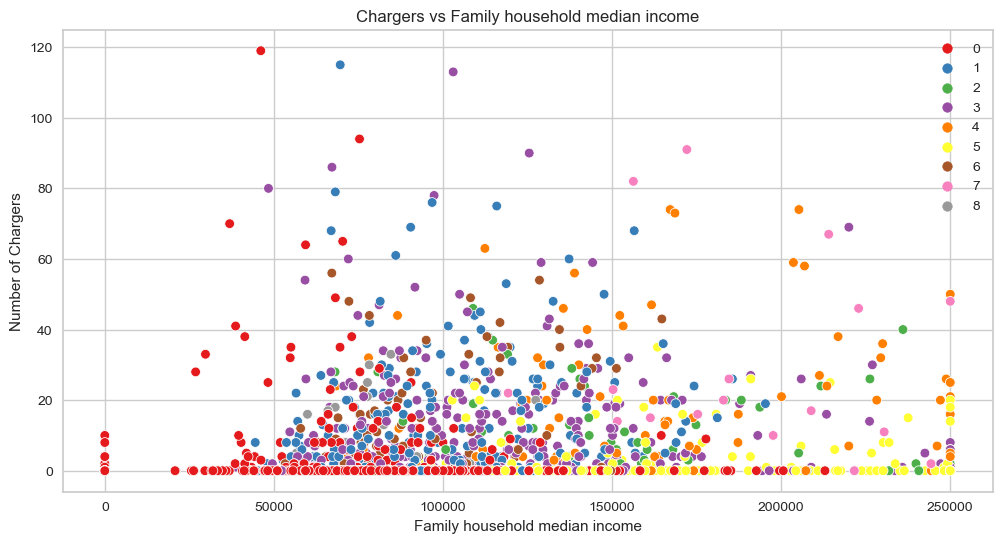

In [89]:
#Scatter plot of Chargers and family household median income
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="chargers_count", x ="family_household_median_income", 
                hue = kmeans_all.labels_, palette="Set1")
plt.title("Chargers vs Family household median income")
plt.xlabel("Family household median income")
plt.ylabel("Number of Chargers")
plt.show()

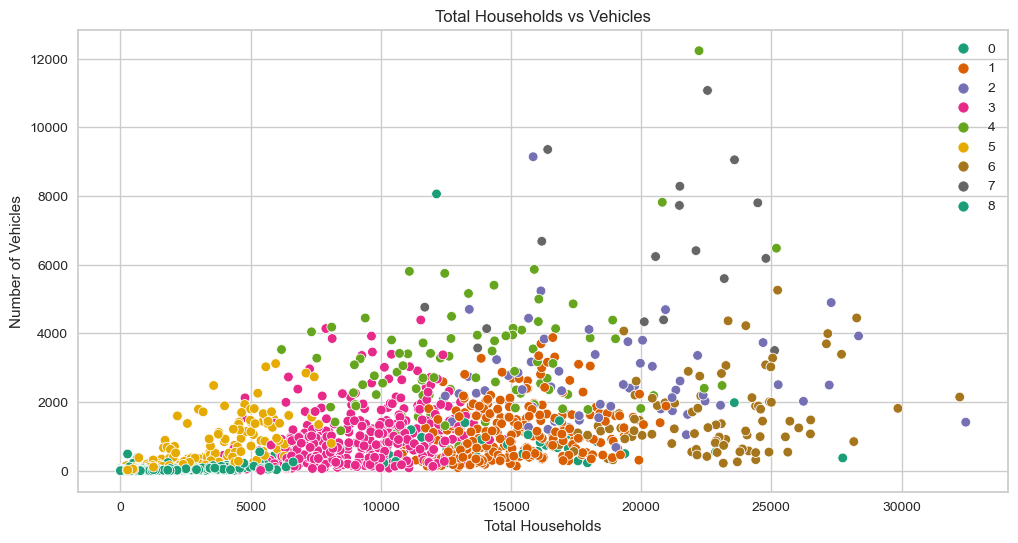

In [90]:
#Scatter plot of vehicles and total number of households  
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="vehicles", x ="total_households", 
                hue = kmeans_all.labels_, palette="Dark2")
plt.title("Total Households vs Vehicles")
plt.xlabel("Total Households")
plt.ylabel("Number of Vehicles")
plt.show()

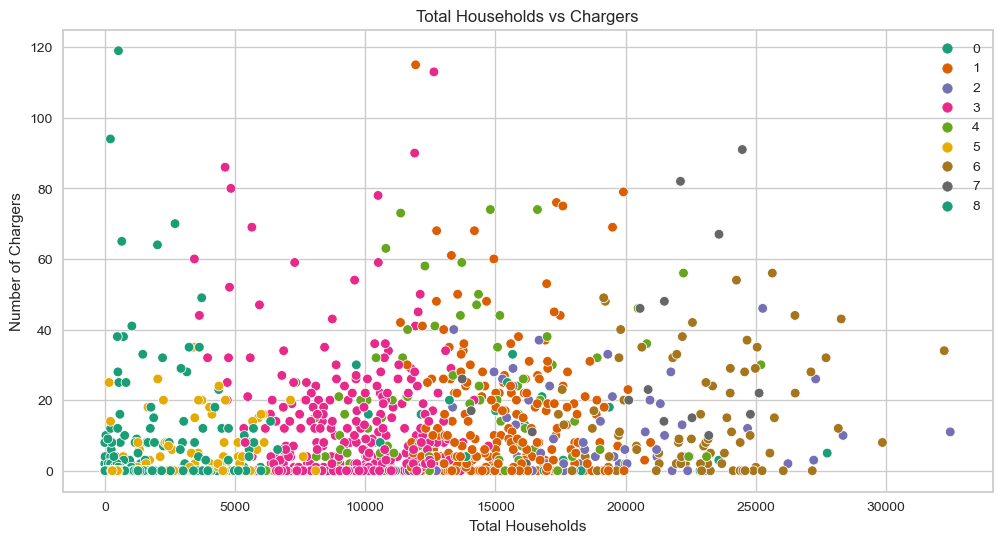

In [91]:
#Scatter plot of chargers and total number of households
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="chargers_count", x ="total_households", 
                hue = kmeans_all.labels_, palette="Dark2")
plt.title("Total Households vs Chargers")
plt.xlabel("Total Households")
plt.ylabel("Number of Chargers")
plt.show()

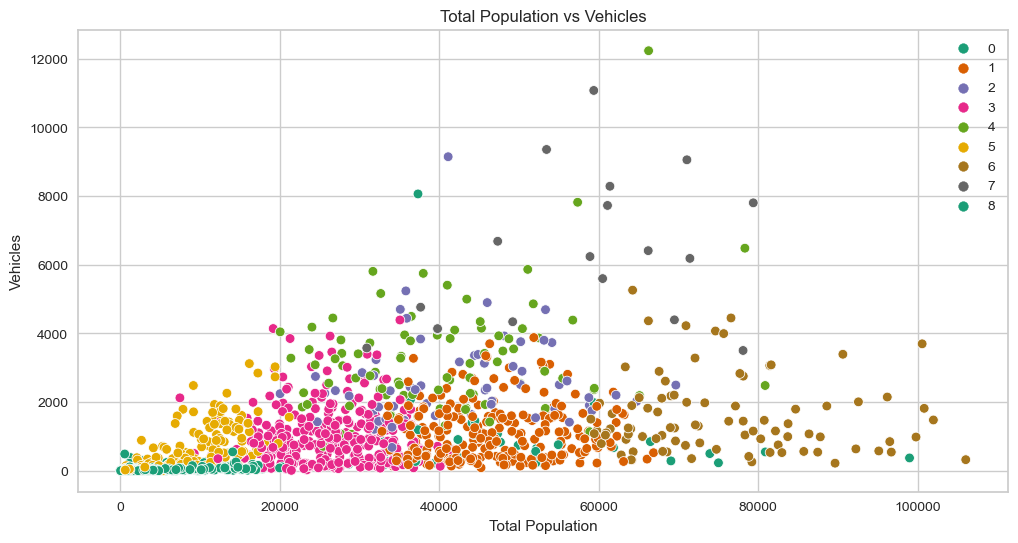

In [92]:
#Scatter plot of vehicles and total number of population
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="vehicles", x ="total_population", 
                hue = kmeans_all.labels_,  palette="Dark2")
plt.title("Total Population vs Vehicles")

plt.xlabel("Total Population")
plt.ylabel("Vehicles")

plt.show()

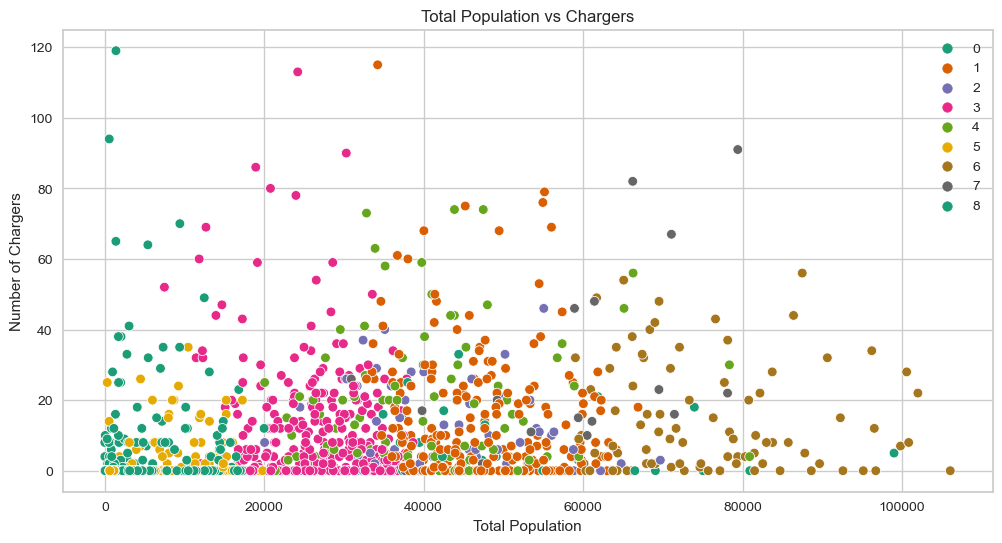

In [93]:
#Scatter plot of chargers and total number of population
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="chargers_count", x ="total_population", 
                hue = kmeans_all.labels_,  palette="Dark2")
plt.title("Total Population vs Chargers")

plt.xlabel("Total Population")
plt.ylabel("Number of Chargers")

plt.show()

### DBSCAN Clustering Algorithm <a id="dbscan"></a>

#### Chargers dataset

##### Optimium epsilon and cluster

In [97]:
#Using nearest neighbors to find optimial epislon
nn = NearestNeighbors(n_neighbors = 5).fit(chargers_scaled_df)
# Find the k-neighbors of a point, interested in distance only
nn_dist, _ = nn.kneighbors(chargers_scaled_df)
# sort the neighbor distances (lengths to points) in ascending order
sort_nn_dist = np.sort(nn_dist, axis = 0)

#Extracting 6th neighbhours distance only for plot
k_dist = sort_nn_dist[:, 4]

Estimated knee point value : 2.4925205627327136


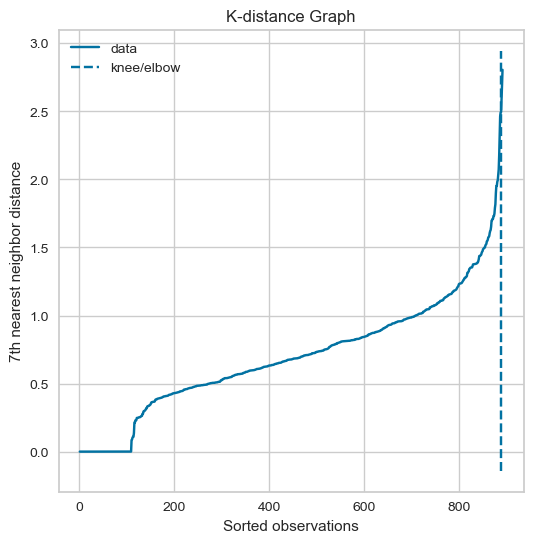

In [98]:
#Using Knee Locator to find optimium eps values
kneedle = KneeLocator(x = range(1, len(nn_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(f"Estimated knee point value : {kneedle.knee_y}")

# distance plot along with knee/elbow
kneedle.plot_knee()
plt.title('K-distance Graph')
plt.ylabel("7th nearest neighbor distance")
plt.xlabel("Sorted observations")

plt.show()

##### Optimium clusters calculation

In [100]:
# DBScan using knee point eps value
dbclusters = DBSCAN(eps=2.5, min_samples=14).fit(chargers_scaled_df)
print(f"DBScan using knee point eps value result in only {len(set(dbclusters.labels_))} clusters, inlcuding noise.")

# DBScan using eps =1 value
dbclusters = DBSCAN(eps=1, min_samples=14).fit(chargers_scaled_df)
print(f"DBScan using eps=1 value result in {len(set(dbclusters.labels_))} clusters")

DBScan using knee point eps value result in only 2 clusters, inlcuding noise.
DBScan using eps=1 value result in 6 clusters


##### Visualizations

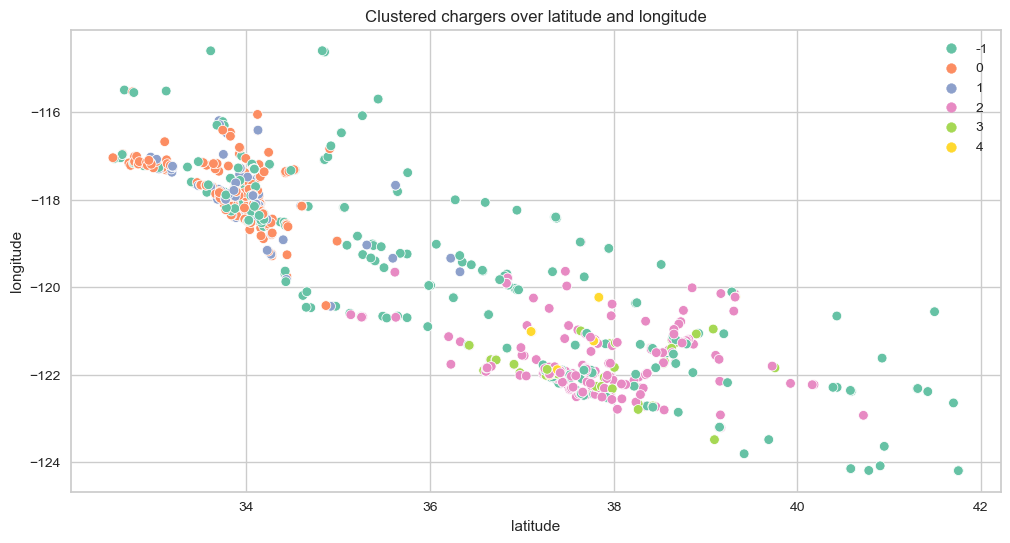

In [102]:
#Scatter plot of Lat, Log clustering
plt.figure(figsize=(12,6))
sns.scatterplot(data=chargers_df, x ="latitude", y="longitude", 
                hue = dbclusters.labels_, 
                palette="Set2")
plt.title("Clustered chargers over latitude and longitude")
plt.show()

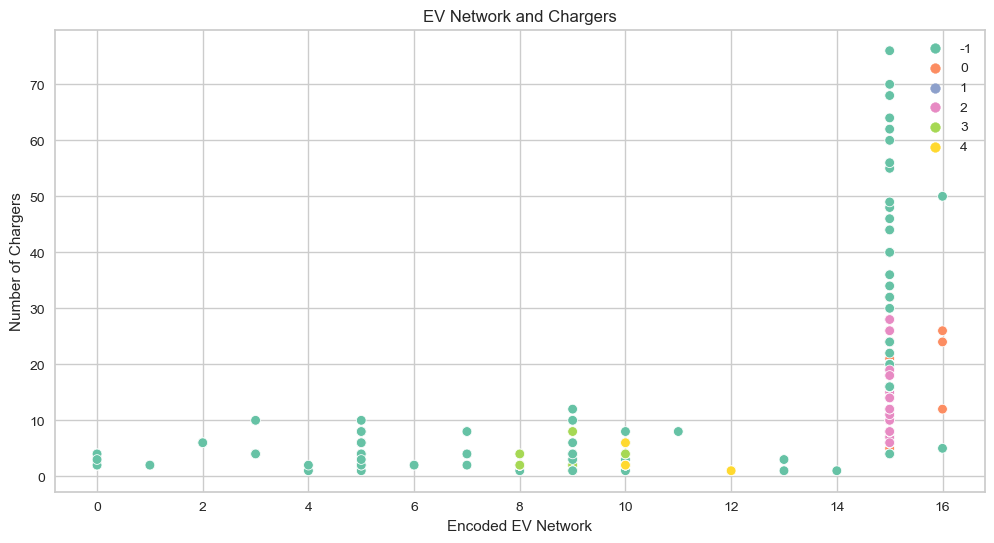

In [103]:
#Scatter plot of Ev Network and chargers
plt.figure(figsize=(12,6))

sns.scatterplot(data=chargers_df, y ="chargers_count", x="ev_network", 
                hue = dbclusters.labels_, 
                palette="Set2")
plt.title("EV Network and Chargers")
plt.xlabel("Encoded EV Network")
plt.ylabel("Number of Chargers")
plt.show()

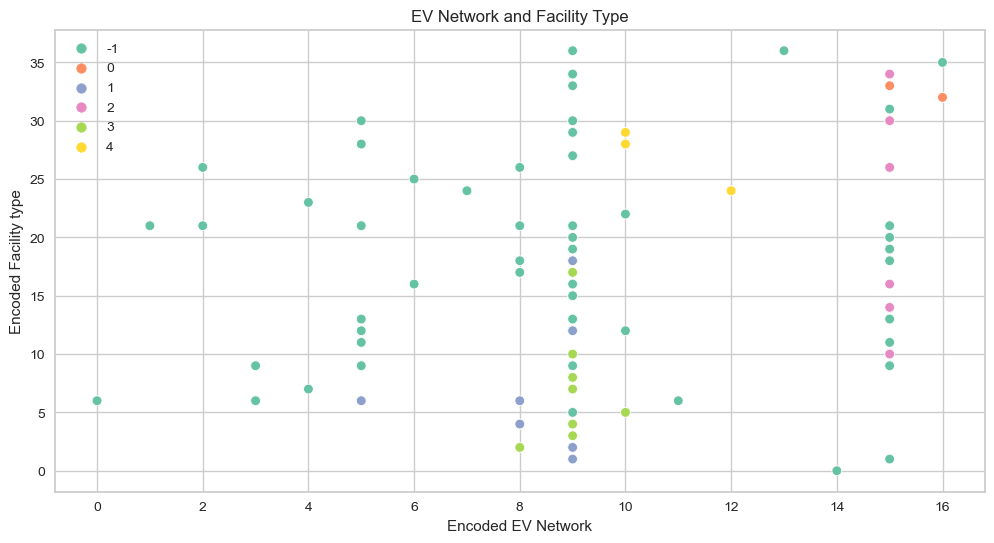

In [104]:
#Scatter plot of Ev Network and Facility Type
plt.figure(figsize=(12,6))

sns.scatterplot(data=chargers_df, y ="facility_type", x="ev_network", 
                hue = dbclusters.labels_, 
                palette="Set2")
plt.title("EV Network and Facility Type")
plt.xlabel("Encoded EV Network")
plt.ylabel("Encoded Facility type")
plt.show()

#### Unified dataset

##### Optimium epsilon and cluster

In [107]:
nn = NearestNeighbors(n_neighbors = 5).fit(scaled_df)
# Find the k-neighbors of a point, interested in distance only
nn_dist, _ = nn.kneighbors(scaled_df)
# sort the neighbor distances (lengths to points) in ascending order
sort_nn_dist = np.sort(nn_dist, axis = 0)

#Extracting 6th neighbhours distance only for plot
k_dist = sort_nn_dist[:, 4]

Estimated knee point value : 4.457906390386819


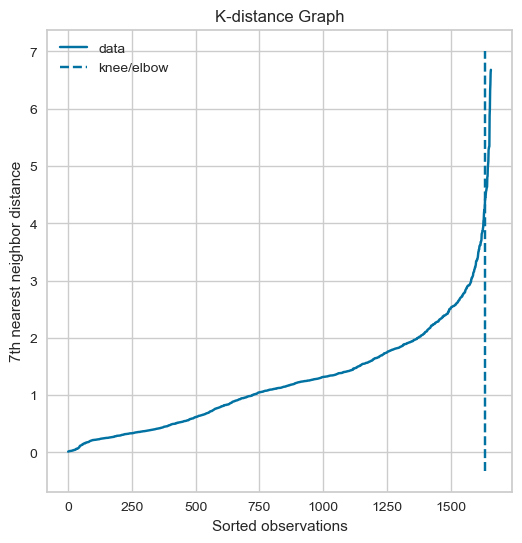

In [108]:
#Using Knee Locator to find optimium eps values
kneedle = KneeLocator(x = range(1, len(nn_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(f"Estimated knee point value : {kneedle.knee_y}")

# distance plot along with knee/elbow
kneedle.plot_knee()
plt.title('K-distance Graph')
plt.ylabel("7th nearest neighbor distance")
plt.xlabel("Sorted observations")

plt.show()

##### Optimium clusters calculation

In [110]:
# DBScan using knee point eps value
all_dbclusters = DBSCAN(eps=4.45, min_samples=14).fit(scaled_df)
print(f"DBScan using knee point eps value result in only {len(set(all_dbclusters.labels_))} clusters, inlcuding noise.")

# DBScan using eps =0.71 value
all_dbclusters = DBSCAN(eps=0.71, min_samples=36).fit(scaled_df)
print(f"DBScan using eps=1 value result in {len(set(all_dbclusters.labels_))} clusters")

DBScan using knee point eps value result in only 2 clusters, inlcuding noise.
DBScan using eps=1 value result in 4 clusters


In [111]:
##### Visualizations

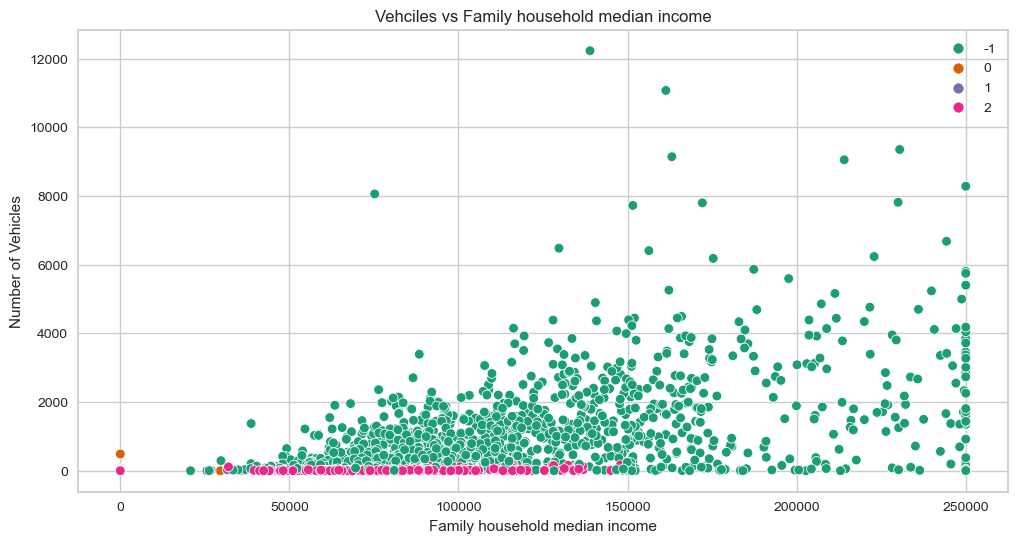

In [112]:
#Scatter plot of vehicles and family household median income
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="vehicles", x ="family_household_median_income", 
                hue = all_dbclusters.labels_, palette="Dark2")
plt.title("Vehciles vs Family household median income")
plt.xlabel("Family household median income")
plt.ylabel("Number of Vehicles")
plt.show()

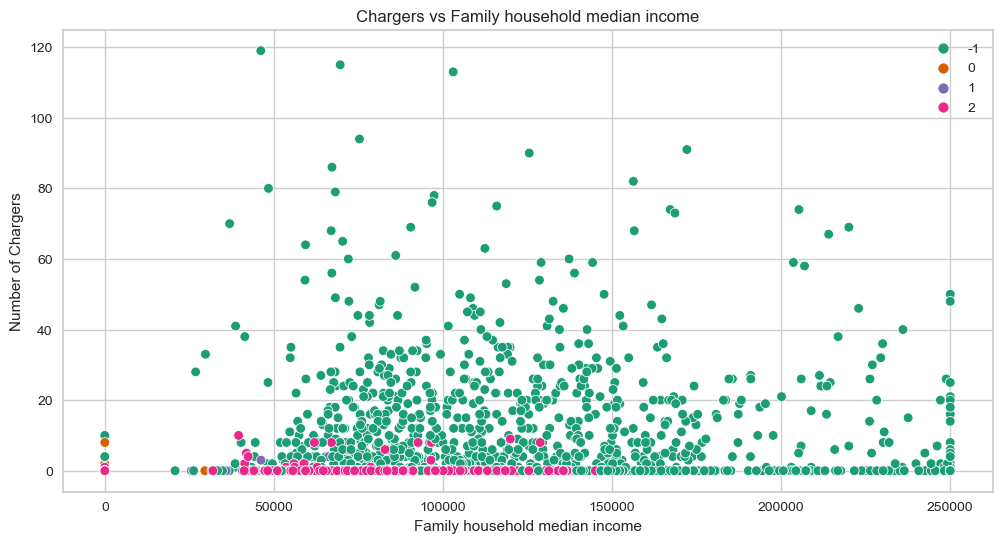

In [113]:
#Scatter plot of Chargers and family household median income
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="chargers_count", x ="family_household_median_income", 
                hue = all_dbclusters.labels_, palette="Dark2")
plt.title("Chargers vs Family household median income")
plt.xlabel("Family household median income")
plt.ylabel("Number of Chargers")
plt.show()

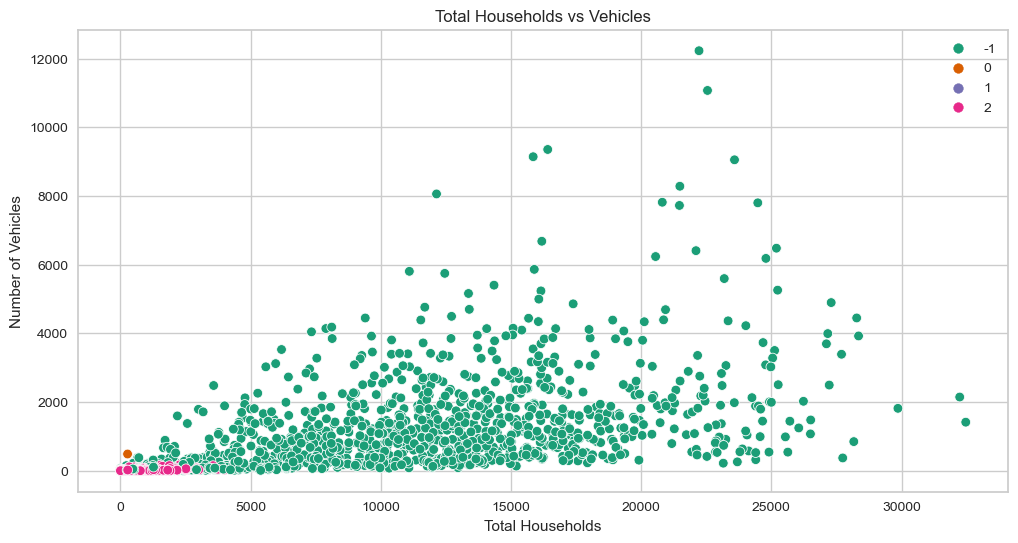

In [114]:
#Scatter plot of vehicles and total number of households  
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="vehicles", x ="total_households", 
                hue = all_dbclusters.labels_, palette="Dark2")
plt.title("Total Households vs Vehicles")
plt.xlabel("Total Households")
plt.ylabel("Number of Vehicles")
plt.show()

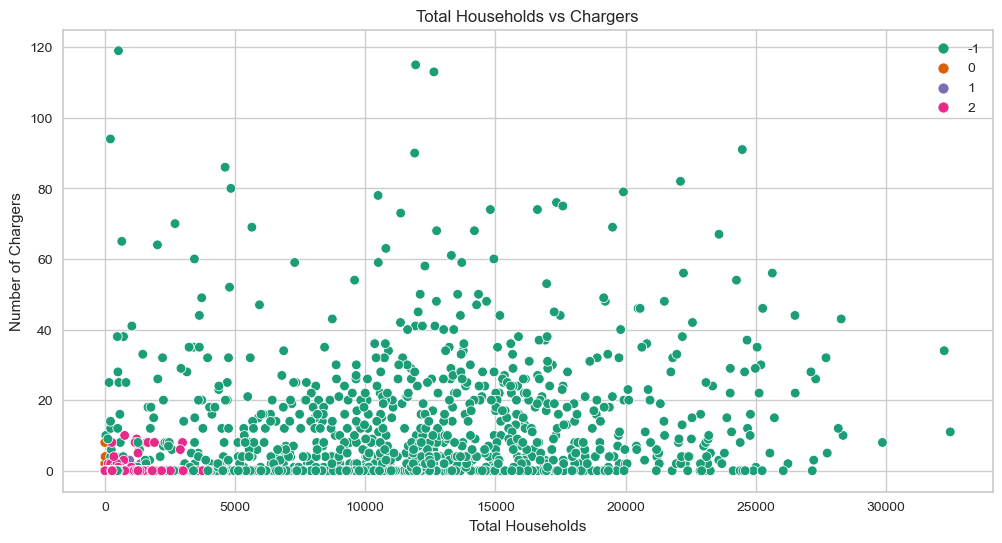

In [115]:
#Scatter plot of chargers and total number of households
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="chargers_count", x ="total_households", 
                hue = all_dbclusters.labels_, palette="Dark2")
plt.title("Total Households vs Chargers")
plt.xlabel("Total Households")
plt.ylabel("Number of Chargers")
plt.show()

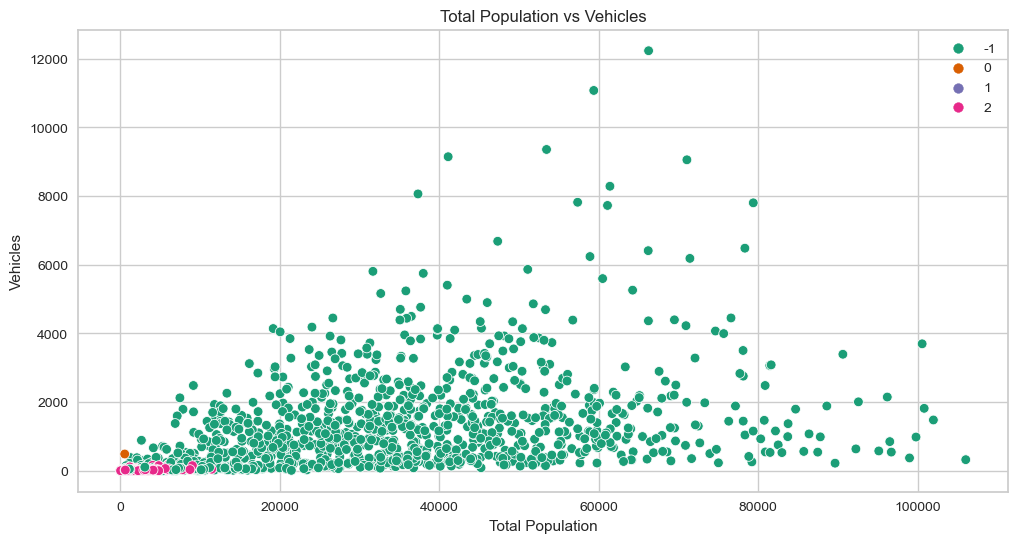

In [116]:
#Scatter plot of vehicles and total number of population
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="vehicles", x ="total_population", 
                hue = all_dbclusters.labels_,  palette="Dark2")
plt.title("Total Population vs Vehicles")

plt.xlabel("Total Population")
plt.ylabel("Vehicles")

plt.show()

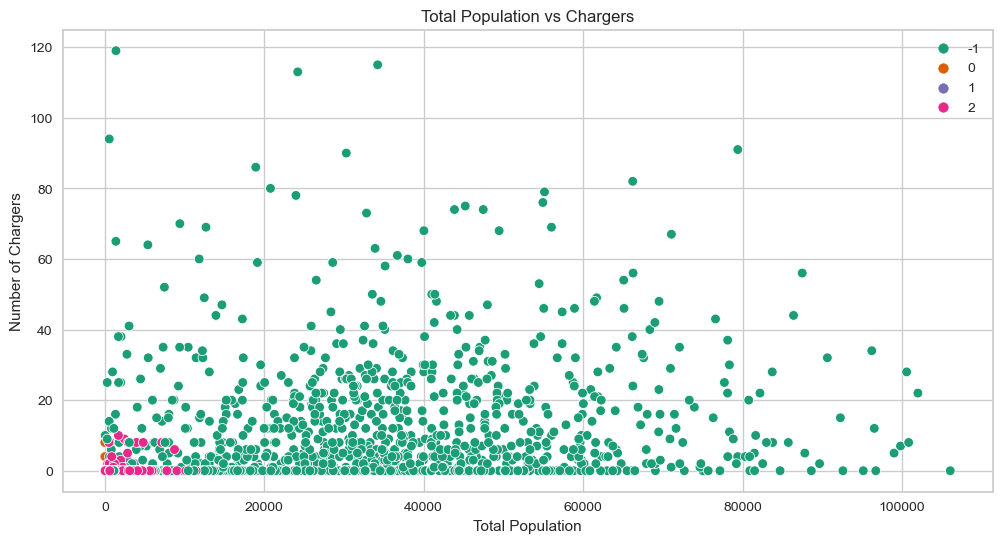

In [117]:
#Scatter plot of chargers and total number of population
plt.figure(figsize=(12,6))
sns.scatterplot(data=all_inclusive_df, y ="chargers_count", x ="total_population", 
                hue = all_dbclusters.labels_,  palette="Dark2")
plt.title("Total Population vs Chargers")

plt.xlabel("Total Population")
plt.ylabel("Number of Chargers")

plt.show()

### Hierarchical Clustering Algorithm <a id="hierachical"></a>

#### Single Linkage

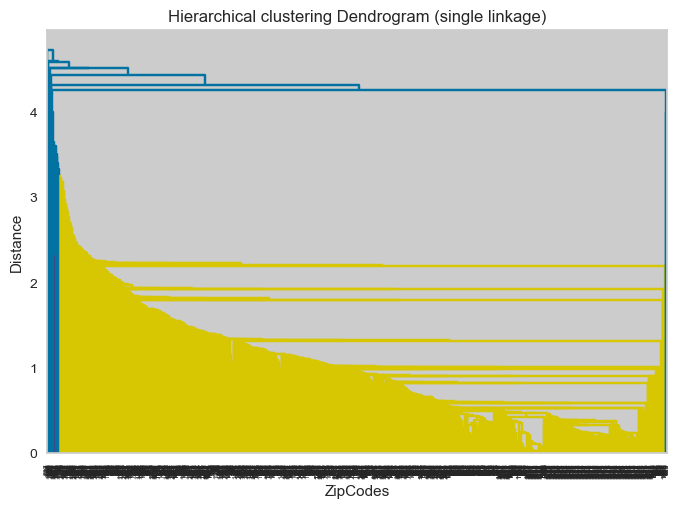

Number of clusters identifed using dendrogram visulation is 2


In [120]:
#Hierarchical Clustering with single linkage
#create single linkage
single_linkage = linkage(scaled_df, method="single", metric="euclidean")

#plot dendrogram
dendrogram(single_linkage)
plt.xlabel("ZipCodes")
plt.ylabel("Distance")
plt.title("Hierarchical clustering Dendrogram (single linkage)")
plt.show()

print("Number of clusters identifed using dendrogram visulation is 2")

In [121]:
#hierarchical clusters flated to see data
cluster_2=fcluster(single_linkage,2,criterion='maxclust')
all_inclusive_df['cluster_2']=cluster_2
mean_features_2=all_inclusive_df.groupby('cluster_2').mean()
mean_features_2

,zip,chargers_count,vehicles,total_households,family_households,nonfamily_households,family_household_median_income,non_family_household_median_income,total_population,all_male,all_female,male_18+,female_18+,white_population,black_population,asian,asian_indian,asian_chinese
cluster_2,,,,,,,,,,,,,,,,,,
1,93610.367372,7.713595,874.852568,8017.817523,5474.597583,2543.21994,104720.83565,50995.685801,23677.059819,11852.089426,11824.970393,9144.952266,9248.735347,11403.545015,1326.085801,3563.150453,507.743807,987.625982
2,92683.000000,32.000000,3392.000000,27692.000000,21525.000000,6167.00000,88407.00000,44942.000000,90630.000000,45026.000000,45604.000000,35976.000000,35435.000000,24327.000000,907.000000,45982.000000,312.000000,1902.000000


#### Complete Linkage

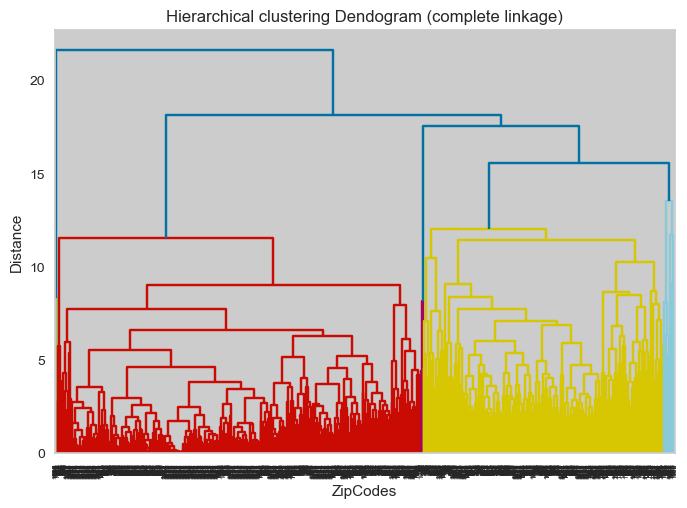

Number of clusters identifed using dendrogram visulation is 5


In [123]:
#Hierarchical Clustering with compelte linkage
#create complete linkage
complete_linkage = linkage(scaled_df, method="complete", metric="euclidean")
#plot dendrogram
dendrogram(complete_linkage)
plt.xlabel("ZipCodes")
plt.ylabel("Distance")
plt.title("Hierarchical clustering Dendogram (complete linkage)")
plt.show()

print("Number of clusters identifed using dendrogram visulation is 5")

In [124]:
#hierarchical clusters flated to see data
cluster_5=fcluster(complete_linkage,5,criterion='maxclust')
all_inclusive_df['cluster_5']=cluster_2
mean_features_5=all_inclusive_df.groupby('cluster_5').mean()
mean_features_5

,zip,chargers_count,vehicles,total_households,family_households,nonfamily_households,family_household_median_income,non_family_household_median_income,total_population,all_male,all_female,male_18+,female_18+,white_population,black_population,asian,asian_indian,asian_chinese,cluster_2
cluster_5,,,,,,,,,,,,,,,,,,,
1,93610.367372,7.713595,874.852568,8017.817523,5474.597583,2543.21994,104720.83565,50995.685801,23677.059819,11852.089426,11824.970393,9144.952266,9248.735347,11403.545015,1326.085801,3563.150453,507.743807,987.625982,1.0
2,92683.000000,32.000000,3392.000000,27692.000000,21525.000000,6167.00000,88407.00000,44942.000000,90630.000000,45026.000000,45604.000000,35976.000000,35435.000000,24327.000000,907.000000,45982.000000,312.000000,1902.000000,2.0


## t-SNE Visualization

### Chargers dataset

In [127]:
#create tsne with 2 dimension 
chargers_tsne = TSNE(n_components=2, perplexity=40, random_state=21)
#fit the data
chargers_tsne_transformed= chargers_tsne.fit_transform(chargers_df)
#print KL divergence
print(f'Kullback-Leibler (KL) divergence : {chargers_tsne.kl_divergence_}')

Kullback-Leibler (KL) divergence : 0.15297818183898926


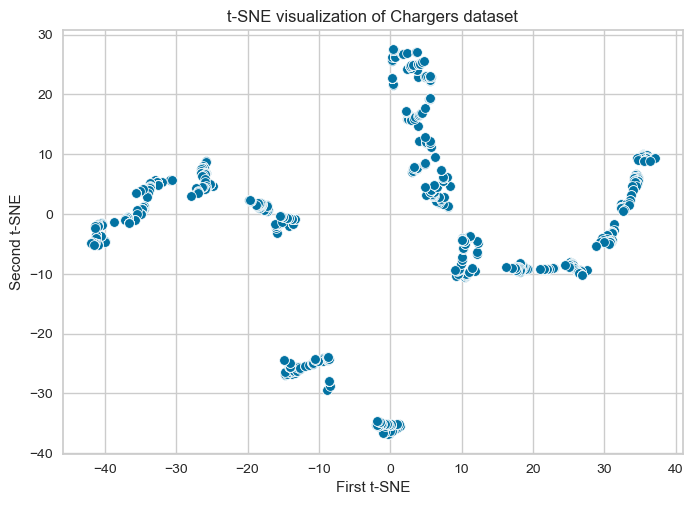

In [128]:
#visualization with scatterplot
sns.scatterplot( x=chargers_tsne_transformed[:, 0], y=chargers_tsne_transformed[:, 1]) 
plt.xlabel("First t-SNE")
plt.ylabel("Second t-SNE")
plt.title("t-SNE visualization of Chargers dataset")
plt.show()

### Unified dataset

In [130]:
#create tsne with 2 dimension 
all_inclusive_tsne = TSNE(n_components=2,perplexity=40, random_state=42)
#fit data
all_inclusive_tsne_transformed = all_inclusive_tsne.fit_transform(all_inclusive_df)
#print KL divergence
print(f'Kullback-Leibler (KL) divergence : {all_inclusive_tsne.kl_divergence_}')

Kullback-Leibler (KL) divergence : 0.6926361322402954


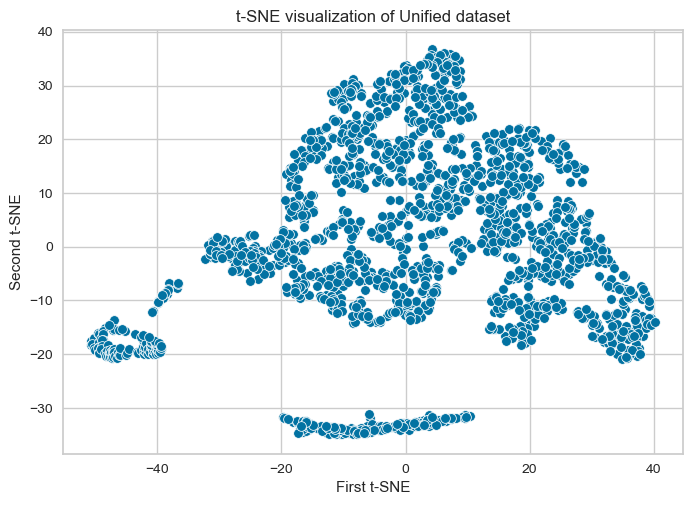

In [131]:
#visualization with scatterplot
sns.scatterplot( x=all_inclusive_tsne_transformed[:, 0], y=all_inclusive_tsne_transformed[:, 1]) 
plt.xlabel("First t-SNE")
plt.ylabel("Second t-SNE")
plt.title("t-SNE visualization of Unified dataset")
plt.show()